In [1]:
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output


from tqdm import tqdm_notebook
from skimage.morphology import binary_opening, disk
import gc; gc.enable() # memory is tight


import traceback
import torchvision
import os
import gc

import numpy as np # linear algebra
from sklearn.model_selection import train_test_split
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import pickle
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool

from os.path import join
sys.path.append("../")
from src import utils

gc.enable()
torch.backends.cudnn.benchmark=True


DATA = "../data/"
MODELS = "../models"
MODEL_CHECKPOINT = join(MODELS, "UNETv1_checkpoint/")
TRAINING_STATS = join(MODEL_CHECKPOINT, "progress.csv")
TRAINED_UNET_MODEL = join(MODEL_CHECKPOINT, "model.pt")
TRAIN_PROGRESS_IMAGES = join(MODEL_CHECKPOINT, "progress/")

SHIP_DIR = "/media/shivam/DATA/airbus-tracking/"
TRAIN_IMAGE_DIR = os.path.join(SHIP_DIR, "train_v2")
TEST_IMAGE_DIR = os.path.join(SHIP_DIR, "test_v2")

CSV_TRAIN = join(DATA, 'balanced_train_df_shipgt_4.csv')
CSV_VALID = join(DATA, 'balanced_valid_df_shipgt_4.csv')


TRAIN_BATCH = 10
VALID_BATCH = 2
TEST_BATCH = 2

# Dataset and preprocessing

In [2]:
class KaggleDataset(Dataset):
    def __init__(self, datapath, phase):
        self.data = pd.read_csv(datapath)
        self.phase = phase
        self.image_ids = np.unique(self.data['ImageId'])
        print("Unique images: {}".format(len(self.image_ids)))
            
    def __len__(self):
        return len(self.image_ids)
    
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(TRAIN_IMAGE_DIR, self.image_ids[idx])
        # c_img = imread(rgb_path)
        c_img = plt.imread(rgb_path)
        c_mask = utils.masks_as_image(self.data[self.data['ImageId'] == self.image_ids[idx]]['EncodedPixels'].tolist())
        
        c_img = np.stack(c_img, 0)/255.0
        c_mask = np.stack(c_mask, 0)
        if self.phase == 'train':
            crop_delta = 200
            factor = 5
            h, w, _ = c_mask.shape
            # Random crop selection trick
            x1 = np.random.randint(0, h-crop_delta)
            x2 = np.random.randint(0, w-crop_delta)
            c_mask = c_mask[x1:x1+crop_delta, x2:x2+crop_delta, :]
            c_img = c_img[x1:x1+crop_delta, x2:x2+crop_delta, :]
        
        c_img = c_img.transpose(-1, 0, 1)
        c_mask = c_mask.transpose(-1, 0, 1)
        return c_img.astype('f'), c_mask.astype('f')    

class Kaggle_Dataset_Test(Dataset):
    def __init__(self, testdir):
        self.testdir = testdir
        self.test_images = os.listdir(testdir)
        
    def __len__(self):
        return len(self.test_images)
    
    def __getitem__(self, idx):
        rgb_path = os.path.join(self.testdir, self.test_images[idx])
        c_img = imread(rgb_path)
        c_img = np.stack(c_img, 0)/255.0
        c_img = c_img.transpose(-1, 0, 1)
        return self.test_images[idx], c_img.astype('f')

# Unet

In [3]:
class double_conv(nn.Module):
    ''' conv -> BN -> relu -> conv -> BN -> relu'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x):
        return self.conv(x)

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )
    
    def forward(self, x):
        return self.mpconv(x)

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, out_ch//2, stride=2)
        
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, (diffX//2, diffX - diffX//2,
                        diffY//2, diffY - diffY//2)
                  )
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
    
def dice_loss(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return 1 - ((2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth))

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64,  128) #x2
        self.down2 = down(128, 256) #x3
        self.down3 = down(256, 512) #x4
        self.down4 = down(512, 512) #x5
        self.up1   = up(1024,256)
        self.up2   = up(512,128)
        self.up3   = up(256,64)
        self.up4   = up(128,64)
        self.outc  = outconv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5,x4) # (x5-512d + x4-512d  = 1024d--> 256d)
        x = self.up2(x,x3)  # (x-256d + x3 - 256d = 512d --> 128d)
        x = self.up3(x, x2) # (x-128d + x2 - 128d = 256d --> 64d)
        x = self.up4(x,x1)  # (x-64d  + x1 - 64d  = 128d --> 64d)
        x = self.outc(x)    # 64d --> n_classes_D
        
        return sigmoid(x)

def train(net, criterion, optimizer, epochs, trainLoader, valLoader):
    print ('Training has begun ...')
    training_stats = []
    for epoch in range(1, epochs+1):
        if (epoch > 1):
            plt.plot(range(epoch-1), np.array(training_stats)[:, 0], color='blue', marker='o', label='Train Loss')
            plt.plot(range(epoch-1), np.array(training_stats)[:, 1], color='orange', marker='o', label='Val Loss')
            plt.title('Loss Values (epoch : {0})'.format(epoch))
            plt.legend()
            plt.show()
        
        running_loss = 0
        val_loss = 0;
        # Train with all available data.
        print("Training in epoch: {}".format(epoch))
        for i, data in tqdm_notebook(enumerate(trainLoader), total = len(trainLoader)):
            X,Y = data
            optimizer.zero_grad()

            # Y_   = net(X.cuda(non_blocking=True))
            Y_   = net(X.cuda(non_blocking=False))

            # loss = criterion(Y_, Y.cuda(non_blocking=True))
            loss = criterion(Y_, Y.cuda(non_blocking=False))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            del loss, X, Y, Y_  ## to be evaluated!!
        
        # Validate after each epoch.
        print("Starting validation...")
        val_loss = test(net, valLoader, criterion, save_im = True, group=epoch)
            
        # Normalize and save
        running_loss /= len(trainLoader)
        val_loss = sum(val_loss)/len(valLoader)
        training_stats.append([running_loss, val_loss])
        pd.DataFrame(training_stats).to_csv(TRAINING_STATS, header = ['running_loss', 'val_loss'], index = False)
        
        clear_output()
        
        # Save model
        if (epoch%5==0):
            print("Saving the model at {} epochs".format(epoch))
            torch.save(net.state_dict(), TRAINED_UNET_MODEL)
        
        # Empty gpu cache
        torch.cuda.empty_cache()
        print("Epoch: {}, running loss: {:.4f}, validation loss: {:.4f}".format(epoch, running_loss, val_loss))
        
        gc.collect()
        
def test(model, validLoader, criterion,  save_im = False, progress_path = TRAIN_PROGRESS_IMAGES, group=None):
    im_c = 0
    loss_scores = []
    with torch.no_grad():
        for i, data in tqdm_notebook(enumerate(validLoader), total=len(validLoader)):
            X, y = data
            y_pred = model(X.cuda())
            loss_scores.append(criterion(y_pred, y.cuda()).item())

            # Save image if specified
            if save_im:
                for b in range(y_pred.shape[0]):

                    y_pred_tmp = y_pred[b, :, :, :].cpu().numpy().transpose(-1, 1, 0)[:, :, 0]
                    y_pred_tmp[y_pred_tmp >= 0.5] = 1
                    y_pred_tmp[y_pred_tmp < 0.5] = 0
                    
                    
                    X_tmp = X[b, :, :, :].numpy().transpose(-1, 1, 0)
                    
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
                    ax1.imshow(X_tmp)
                    ax1.set_title("Original image")
                    ax2.imshow(y_pred_tmp, cmap=plt.cm.gray)
                    ax2.set_title("Predicted segmentation")
                    figname = join(progress_path, "img{}_{}".format(im_c, group if group else "test"))
                    fig.savefig(fname=figname, bbox_inches = 'tight', pad_inches = 0)
                    plt.close()
                    im_c += 1
            
            del X,y, y_pred


    return loss_scores

# Initializing for training

In [4]:
# Load in Dataset
trainDataset = KaggleDataset(CSV_TRAIN, 'train')
validDataset = KaggleDataset(CSV_VALID, 'valid')
testDataset = Kaggle_Dataset_Test(TEST_IMAGE_DIR)

Unique images: 4740
Unique images: 48


(3, 200, 200)
(3, 200, 200) (1, 200, 200)


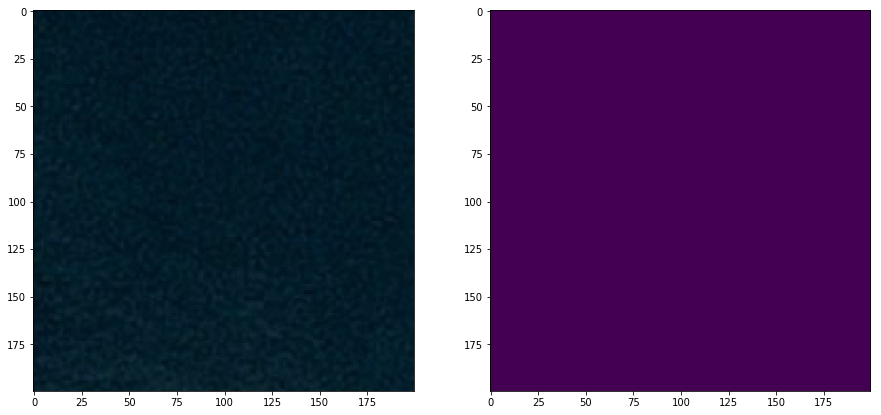

In [5]:
def show(x, y):
    f, axarr = plt.subplots(1,2, figsize=(15, 15))
    print (x.shape, y.shape)
    axarr[0].imshow(x.transpose(-1, 1, 0))
    axarr[1].imshow(y.transpose(-1, 1, 0)[:, :, 0])
    
e = trainDataset[105]
print(e[0].shape)
show(e[0], e[1])

# Training

In [6]:
# Construct UNet
gc.collect()
reuse = False

net = UNet(3, 1).cuda()
if reuse:
    print("Reusing model from: {}".format(TRAINED_UNET_MODEL))
    net.load_state_dict(torch.load(TRAINED_UNET_MODEL))
    net.eval()
    
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
criterion = nn.BCELoss()

# Training the model
trainDataLoader   = torch.utils.data.DataLoader(
        trainDataset
        , batch_size=TRAIN_BATCH,shuffle=True
        , num_workers=1, pin_memory=True)

validDataLoader   = torch.utils.data.DataLoader(
        validDataset
        , batch_size=VALID_BATCH,shuffle=False
        , num_workers=0, pin_memory=True)

In [7]:
train(net, criterion, optimizer, 100, trainDataLoader, validDataLoader)

Saving the model at 100 epochs
Epoch: 100, running loss: 0.0131, validation loss: 0.0138


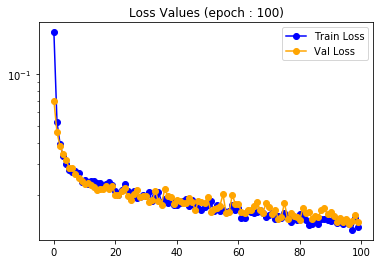

In [11]:
training_stats = pd.read_csv(TRAINING_STATS)
plt.plot(range(100), np.array(training_stats)[:, 0], color='blue', marker='o', label='Train Loss', )
plt.plot(range(100), np.array(training_stats)[:, 1], color='orange', marker='o', label='Val Loss')
plt.yscale('log')
plt.title('Loss Values (epoch : {0})'.format(100))
plt.legend()
plt.show()

# Inference

In [6]:
# Encoding functions for found masks
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


#Load testing images
testDataLoader   = torch.utils.data.DataLoader(
        testDataset
        , batch_size=TEST_BATCH,shuffle=False
        , num_workers=4, pin_memory=True)
print("Number of test images found: {}".format(len(testDataLoader)))

# Load inference model
net = UNet(3, 1).cuda()
net.load_state_dict(torch.load(TRAINED_UNET_MODEL))
net.eval()
clear_output()

In [ ]:
from skimage.morphology import label
out_pred_rows = []
with torch.no_grad():
    for i, data in tqdm_notebook(enumerate(testDataLoader), total=len(testDataLoader)):
        c_img_name, X = data
        y_pred = net(X.cuda())

        for b in range(y_pred.shape[0]):
            y_pred_tmp = y_pred[b, :, :, :].cpu().numpy().transpose(-1, 1, 0)
            y_pred_tmp[y_pred_tmp >= 0.5] = 1
            y_pred_tmp[y_pred_tmp < 0.5] = 0

            cur_rles = multi_rle_encode(y_pred_tmp)
            if len(cur_rles)>0:
                for c_rle in cur_rles:
                    out_pred_rows += [{'ImageId': c_img_name[b], 'EncodedPixels': c_rle}]
            else:
                out_pred_rows += [{'ImageId': c_img_name[b], 'EncodedPixels': None}]
            gc.collect()

/home/shivam/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [15]:
out_pred_rows

[{'ImageId': '00002bd58.jpg', 'EncodedPixels': None},
 {'ImageId': '00015efb6.jpg', 'EncodedPixels': None}]

In [ ]:
# Save dataframe to submission file.
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(3)

# Rough

In [ ]:
class KaggleDataset(Dataset):
    
    def __init__(self, ship_dir):
        self.ship_dir = ship_dir
        self.train_image_dir = os.path.join(self.ship_dir, 'train_v2')
        self.test_image_dir = os.path.join(self.ship_dir, 'test_v2')
        print("Starting preprocess")
        self.preprocess_pickle()
        
    def preprocess_pickle(self):
        with open('all_batches_balancedTrain.pickle', 'rb') as f:
            self.all_batches_balancedTrain = pickle.load(f)
        with open('all_batches_balancedValid.pickle', 'rb') as f:
            self.all_batches_balancedValid = pickle.load(f)

    def preprocess(self):
        
        def sample_ships(in_df, base_rep_val=1500):
            if in_df['ships'].values[0]==0:
                return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
            else:
                return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
        masks = pd.read_csv(os.path.join(self.ship_dir, 'train_ship_segmentations_v2.csv'))
        
        masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
        unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
        print("Reach 1")
        unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
        unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
        # some files are too small/corrupt
        print("Reach 1.2")
        unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                                       os.stat(os.path.join(self.train_image_dir, 
                                                                                            c_img_id)).st_size/1024)
        print("Reach 2")
        unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
        masks.drop(['ships'], axis=1, inplace=True)
        train_ids, valid_ids = train_test_split(unique_img_ids, 
                         test_size = 0.3, 
                         stratify = unique_img_ids['ships'])
        
        
        print("Reach 3")
        train_df = pd.merge(masks, train_ids)
        valid_df = pd.merge(masks, valid_ids)
        train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)

        
        print("Reach 4")
        balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
        print("Creating list")
        self.all_batches_balancedTrain = list(balanced_train_df.groupby('ImageId'))
        self.all_batches_balancedValid = list(valid_df.groupby('ImageId'))
        
        with open('all_batches_balancedTrain.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.all_batches_balancedTrain, f, pickle.HIGHEST_PROTOCOL)

        with open('all_batches_balancedValid.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.all_batches_balancedValid, f, pickle.HIGHEST_PROTOCOL)
            
    def __len__(self):
        return len(self.all_batches_balancedTrain)
    
    def multi_rle_encode(self, img):
        labels = label(img[:, :, 0])
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

    # ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
    def rle_encode(self, img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Returns run length as string formated
        '''
        pixels = img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

    def rle_decode(self, mask_rle, shape=(768, 768)):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, 1 - mask, 0 - background
        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape).T  # Needed to align to RLE direction

    def masks_as_image(self, in_mask_list):
        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768), dtype = np.int16)
        #if isinstance(in_mask_list, list):
        for mask in in_mask_list:
            if isinstance(mask, str):
                all_masks += self.rle_decode(mask)
        return np.expand_dims(all_masks, -1)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.train_image_dir, self.all_batches_balancedTrain[idx][0])
        c_img = imread(rgb_path)
        c_mask = self.masks_as_image( self.all_batches_balancedTrain[idx][1]['EncodedPixels'].values)
        
        c_img = np.stack(c_img, 0)/255.0
        c_mask = np.stack(c_mask, 0)
        
        c_img = resize(c_img, (c_img.shape[0] / 2, c_img.shape[1] / 2),
                       anti_aliasing=True)
        
        c_mask = resize(c_mask, (c_mask.shape[0] / 2, c_mask.shape[1] / 2),
                       anti_aliasing=True)
        
        c_img = c_img.transpose(-1, 0, 1)
        c_mask = c_mask.transpose(-1, 0, 1)
        
        
        return c_img, c_mask

    def show(self, x, y):
        f, axarr = plt.subplots(1,2, figsize=(15, 15))

        axarr[0].imshow(x.transpose(-1, 1, 0))
        axarr[1].imshow(y.transpose(-1, 1, 0)[:, :, 0])
            

if(10):
    ship_dir = '/media/shivam/DATA/airbus-tracking/'
    trainDataset = KaggleDataset(ship_dir)

In [ ]:

# # x, y = trainDataset[1]

# # yp = np.ones_like(y)
y = torch.from_numpy(np.random.random((4, 1, 153, 153)))
y = torch.from_numpy(np.random.random((4, 1, 153, 153)))
yp = torch.from_numpy(np.random.random((4, 1, 153, 153)))

# print(dice_coeff(y, yp))

In [ ]:
idx = np.random.randint(0,len(trainDataset.all_batches_balancedTrain))
# idx = 57
factor = 5
print(idx)

rgb_path = os.path.join(trainDataset.train_image_dir, trainDataset.all_batches_balancedTrain[idx][0])
c_img = imread(rgb_path)
c_mask = trainDataset.masks_as_image( trainDataset.all_batches_balancedTrain[idx][1]['EncodedPixels'].values)



h, w, _ = c_mask.shape
c = 192

x1 = np.random.randint(0, h-c)
x2 = np.random.randint(0, w-c)

c_img_s = c_img[x1:x1+c, x2:x2+c, :]
c_mask_s = c_mask[x1:x1+c, x2:x2+c, :]

# c_img_s = resize(c_img, (c_img.shape[0] // factor, c_img.shape[1] // factor), anti_aliasing=False)
# c_mask_s = img_as_bool(resize(c_mask, (c_mask.shape[0] // factor, c_mask.shape[1] // factor), anti_aliasing=False))
# c_mask_s = resize(c_mask, (c_mask.shape[0] // factor, c_mask.shape[1] // factor), anti_aliasing=False)

# c_mask_s = resize(c_mask, (c_mask.shape[0] // factor, c_mask.shape[1] // factor), anti_aliasing=False)
# c_mask_s[c_mask_s < 0.5] = 0
# c_mask_s[c_mask_s >= 0.5] = 1

# from torchvision.transforms import RandomCrop

# func = RandomCrop(192)

# c_mask_s = func(torch.from_numpy(c_mask))

print(np.sum(c_mask_s))
# print(c_img.shape, c_mask.shape)
# print(c_img_s.shape, c_mask_s.shape)
f, axarr = plt.subplots(2,2, figsize=(15,15))
axarr[0][0].imshow(c_img)
axarr[0][1].imshow(c_mask[:,:,0])
axarr[1][0].imshow(c_img_s)
axarr[1][1].imshow(c_mask_s[:,:,0])

# print (trainDataset.all_batches_balancedTrain[idx][1])